In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

dataset építése:

In [2]:
fires = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_dates.csv")
places = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_places.csv")
weather = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_weather.csv")


C:\Users\Bence\AppData\Local\Temp\ipykernel_20164\175859139.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_weather.csv")


In [3]:
fires = fires.drop(fires[fires["confidence"] < 100].index)
fires["acq_date"] = pd.to_datetime(fires["acq_date"], errors="coerce")
weather["time"] = pd.to_datetime(weather["time"], errors="coerce")
fires_daily = (
    fires.groupby("acq_date")
    .size()
    .reset_index(name="fire_count")
)
fires_daily["fire_occurred"] = (fires_daily["fire_count"] > 0).astype(int)

In [4]:
places = places.drop(columns=["elevation", "utc_offset_seconds", "timezone", "timezone_abbreviation"])

weather = weather.merge(places, on="location_id", how="left")
numeric_cols = weather.select_dtypes(include=[np.number]).columns
# Group weather by day, aggregate with mean, keep original column names
weather_daily = weather.groupby("time")[numeric_cols].mean().reset_index()

In [5]:
#weather.head().dtypes

In [6]:
# Merge daily weather and fire data for timeseries creation
df = weather_daily.merge(fires_daily, left_on="time", right_on="acq_date", how="left")
# df = df.drop(columns="time")
df["fire_occurred"].fillna(0, inplace=True)
df.drop(columns=["acq_date"], inplace=True, errors="ignore")
#df.head().dtypes

C:\Users\Bence\AppData\Local\Temp\ipykernel_20164\550816031.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fire_occurred"].fillna(0, inplace=True)


In [ ]:
df["fire_count"].fillna(0, inplace=True)
df.sort_values("time", inplace=True)
df.reset_index(drop=True, inplace=True)


        time  weather_code (wmo code)  temperature_2m_mean (°C)  \
0 2000-01-18                     42.6                      4.70   
1 2000-01-19                     58.6                      5.46   
2 2000-01-20                     26.0                      1.50   
3 2000-01-21                      2.4                      1.64   
4 2000-01-22                     50.2                      4.44   

   temperature_2m_max (°C)  temperature_2m_min (°C)  \
0                     8.66                     0.92   
1                     8.28                     2.20   
2                     4.16                    -1.02   
3                     5.58                    -1.96   
4                     7.96                     0.68   

   apparent_temperature_mean (°C)  apparent_temperature_max (°C)  \
0                            0.68                           3.90   
1                            1.88                           5.80   
2                           -3.18                          -0.

C:\Users\Bence\AppData\Local\Temp\ipykernel_20164\1877599873.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fire_count"].fillna(0, inplace=True)


In [8]:
window_size = 30  # múltbeli napok
forecast_horizon = 7  # előrejelzési idő

feature_cols = [
    col
    for col in df.columns
    if col
    in [
        "temperature_2m_max (°C)",
        "temperature_2m_min (°C)",
        "apparent_temperature_max (°C)",
        "apparent_temperature_min (°C)",
        #"sunrise (iso8601)",
        #"sunset (iso8601)",
        "daylight_duration (s)",
        "sunshine_duration (s)",
        "precipitation_sum (mm)",
        "rain_sum (mm)",
        "snowfall_sum (cm)",
        "precipitation_hours (h)",
        "wind_speed_10m_max (km/h)",
        "wind_gusts_10m_max (km/h)",
        "wind_direction_10m_dominant (°)",
        "shortwave_radiation_sum (MJ/m²)",
        "et0_fao_evapotranspiration (mm)"
    ]
]
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

X, y = [], []

for i in range(len(df_scaled) - window_size - forecast_horizon):
    past_window = df_scaled.iloc[i : i + window_size][feature_cols].values
    target_window = df_scaled.iloc[
        i + window_size : i + window_size + forecast_horizon
    ]["fire_occurred"]
    X.append(past_window)
    y.append(1 if target_window.max() > 0 else 0)


X = np.array(X)
y = np.array(y).astype(np.float32)

print(f"Input shape: {X.shape}  (samples, time_steps, features)")
print(f"Target shape: {y.shape}")

np.savez_compressed("greece_fire_timeseries.npz", X=X, y=y)


Input shape: (7982, 30, 15)  (samples, time_steps, features)
Target shape: (7982,)


In [9]:
cols_scaled = df_scaled.columns.tolist()
print(len(cols_scaled))
cols_df = df.columns.tolist()
print(len(cols_df))
print(len(feature_cols))
print(feature_cols)

23
23
15
['temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)', 'daylight_duration (s)', 'sunshine_duration (s)', 'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'precipitation_hours (h)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)', 'et0_fao_evapotranspiration (mm)']


Model tanítás:

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import TimeSeriesSplit
import joblib
import datetime

# TensorBoard setup for Keras
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

# Adatok betöltése
data = np.load("greece_fire_timeseries.npz")
X = data["X"]
y = data["y"]

print("Input shape:", X.shape)
print("Target shape:", y.shape)

# Train-test split
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}: Train={len(train_idx)}, Test={len(test_idx)}")
    X_train, X_test = X[train_idx].astype(np.float32), X[test_idx].astype(np.float32)
    y_train, y_test = y[train_idx].astype(np.float32), y[test_idx].astype(np.float32)

    # Reshape targets for Keras (samples, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

    # Check for NaN/Inf in data
    print("NaN in X_train:", np.isnan(X_train).sum(), "NaN in y_train:", np.isnan(y_train).sum())
    print("Inf in X_train:", np.isinf(X_train).sum(), "Inf in y_train:", np.isinf(y_train).sum())

    # Simpler LSTM model for binary classification
    model = Sequential([
        LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Kimenet 0-1 között
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Tanítás
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=64,
        callbacks=[early_stop, tensorboard_callback],
        verbose=1
    )
    # Modell mentése
    joblib.dump(model, f'model_fold{fold+1}.pkl')

    # Értékelés
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\n✅ Teszt pontosság (Fold {fold+1}): {acc*100:.2f}%")

Input shape: (7982, 30, 15)
Target shape: (7982,)
Fold 1: Train=1332, Test=1330
Train shape: (1332, 30, 15), Test shape: (1330, 30, 15)
y_train shape: (1332, 1), y_test shape: (1330, 1)
NaN in X_train: 0 NaN in y_train: 0
Inf in X_train: 0 Inf in y_train: 0
Epoch 1/30
21/21 [==============================] - 5s 167ms/step - loss: 0.5622 - accuracy: 0.7650 - val_loss: 0.5081 - val_accuracy: 0.7880
Epoch 2/30
21/21 [==============================] - 3s 149ms/step - loss: 0.4597 - accuracy: 0.7935 - val_loss: 0.3428 - val_accuracy: 0.7880
Epoch 3/30
21/21 [==============================] - 3s 153ms/step - loss: 0.3913 - accuracy: 0.7853 - val_loss: 0.3431 - val_accuracy: 0.7955
Epoch 4/30
21/21 [==============================] - 3s 157ms/step - loss: 0.3723 - accuracy: 0.8003 - val_loss: 0.3217 - val_accuracy: 0.8759
Epoch 5/30
21/21 [==============================] - 3s 158ms/step - loss: 0.3674 - accuracy: 0.7958 - val_loss: 0.3252 - val_accuracy: 0.8368
Epoch 6/30
21/21 [==============

42/42 [==============================] - 1s 18ms/step - loss: 0.2982 - accuracy: 0.9068

✅ Teszt pontosság (Fold 1): 90.68%
Fold 2: Train=2662, Test=1330
Train shape: (2662, 30, 15), Test shape: (1330, 30, 15)
y_train shape: (2662, 1), y_test shape: (1330, 1)
NaN in X_train: 0 NaN in y_train: 0
Inf in X_train: 0 Inf in y_train: 0
Epoch 1/30
42/42 [==============================] - 7s 145ms/step - loss: 0.4752 - accuracy: 0.7915 - val_loss: 0.4926 - val_accuracy: 0.7955
Epoch 2/30
42/42 [==============================] - 6s 139ms/step - loss: 0.3435 - accuracy: 0.8392 - val_loss: 0.4577 - val_accuracy: 0.8226
Epoch 3/30
42/42 [==============================] - 6s 139ms/step - loss: 0.3381 - accuracy: 0.8535 - val_loss: 0.4575 - val_accuracy: 0.8414
Epoch 4/30
42/42 [==============================] - 6s 140ms/step - loss: 0.3221 - accuracy: 0.8584 - val_loss: 0.4464 - val_accuracy: 0.8466
Epoch 5/30
42/42 [==============================] - 6s 141ms/step - loss: 0.3270 - accuracy: 0.8542 

INFO:tensorflow:Assets written to: ram://078706cf-66d6-4367-82ee-62f22dc0d538/assets


42/42 [==============================] - 1s 18ms/step - loss: 0.4093 - accuracy: 0.8481

✅ Teszt pontosság (Fold 2): 84.81%
Fold 3: Train=3992, Test=1330
Train shape: (3992, 30, 15), Test shape: (1330, 30, 15)
y_train shape: (3992, 1), y_test shape: (1330, 1)
NaN in X_train: 0 NaN in y_train: 0
Inf in X_train: 0 Inf in y_train: 0
Epoch 1/30
63/63 [==============================] - 10s 139ms/step - loss: 0.4617 - accuracy: 0.7923 - val_loss: 0.2892 - val_accuracy: 0.8835
Epoch 2/30
63/63 [==============================] - 8s 134ms/step - loss: 0.3701 - accuracy: 0.8447 - val_loss: 0.2378 - val_accuracy: 0.8947
Epoch 3/30
63/63 [==============================] - 8s 134ms/step - loss: 0.3619 - accuracy: 0.8464 - val_loss: 0.2414 - val_accuracy: 0.8872
Epoch 4/30
63/63 [==============================] - 9s 136ms/step - loss: 0.3552 - accuracy: 0.8525 - val_loss: 0.2795 - val_accuracy: 0.9083
Epoch 5/30
63/63 [==============================] - 8s 134ms/step - loss: 0.3473 - accuracy: 0.8550

INFO:tensorflow:Assets written to: ram://92c8a032-8820-4322-b68d-43a64e93f23d/assets


42/42 [==============================] - 1s 19ms/step - loss: 0.1997 - accuracy: 0.9218

✅ Teszt pontosság (Fold 3): 92.18%
Fold 4: Train=5322, Test=1330
Train shape: (5322, 30, 15), Test shape: (1330, 30, 15)
y_train shape: (5322, 1), y_test shape: (1330, 1)
NaN in X_train: 0 NaN in y_train: 0
Inf in X_train: 0 Inf in y_train: 0
Epoch 1/30
84/84 [==============================] - 13s 137ms/step - loss: 0.4171 - accuracy: 0.8082 - val_loss: 0.4334 - val_accuracy: 0.8346
Epoch 2/30
84/84 [==============================] - 11s 135ms/step - loss: 0.3394 - accuracy: 0.8625 - val_loss: 0.4355 - val_accuracy: 0.8429
Epoch 3/30
84/84 [==============================] - 11s 133ms/step - loss: 0.3234 - accuracy: 0.8655 - val_loss: 0.4458 - val_accuracy: 0.8406
Epoch 4/30
84/84 [==============================] - 11s 133ms/step - loss: 0.3232 - accuracy: 0.8672 - val_loss: 0.4488 - val_accuracy: 0.8218
Epoch 5/30
84/84 [==============================] - 11s 133ms/step - loss: 0.3205 - accuracy: 0.

INFO:tensorflow:Assets written to: ram://9925aeec-f70c-4628-a081-f2ce5f1d109b/assets


42/42 [==============================] - 1s 18ms/step - loss: 0.4334 - accuracy: 0.8346

✅ Teszt pontosság (Fold 4): 83.46%
Fold 5: Train=6652, Test=1330
Train shape: (6652, 30, 15), Test shape: (1330, 30, 15)
y_train shape: (6652, 1), y_test shape: (1330, 1)
NaN in X_train: 0 NaN in y_train: 0
Inf in X_train: 0 Inf in y_train: 0
Epoch 1/30
104/104 [==============================] - 16s 136ms/step - loss: 0.4299 - accuracy: 0.7983 - val_loss: 0.4382 - val_accuracy: 0.7767
Epoch 2/30
104/104 [==============================] - 14s 135ms/step - loss: 0.3581 - accuracy: 0.8540 - val_loss: 0.4257 - val_accuracy: 0.8060
Epoch 3/30
104/104 [==============================] - 14s 135ms/step - loss: 0.3453 - accuracy: 0.8615 - val_loss: 0.4532 - val_accuracy: 0.7692
Epoch 4/30
104/104 [==============================] - 14s 136ms/step - loss: 0.3391 - accuracy: 0.8615 - val_loss: 0.4320 - val_accuracy: 0.8128
Epoch 5/30
104/104 [==============================] - 14s 135ms/step - loss: 0.3312 - ac

INFO:tensorflow:Assets written to: ram://239c77e2-ef5a-4c4f-b1eb-0d7a8549a22c/assets


42/42 [==============================] - 1s 19ms/step - loss: 0.4000 - accuracy: 0.8301

✅ Teszt pontosság (Fold 5): 83.01%


In [ ]:
#evolved version of the NN


In [11]:
# TensorBoard setup for Keras
from tensorflow.keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

In [14]:

model.save(f"model_fold{fold+1}.h5")

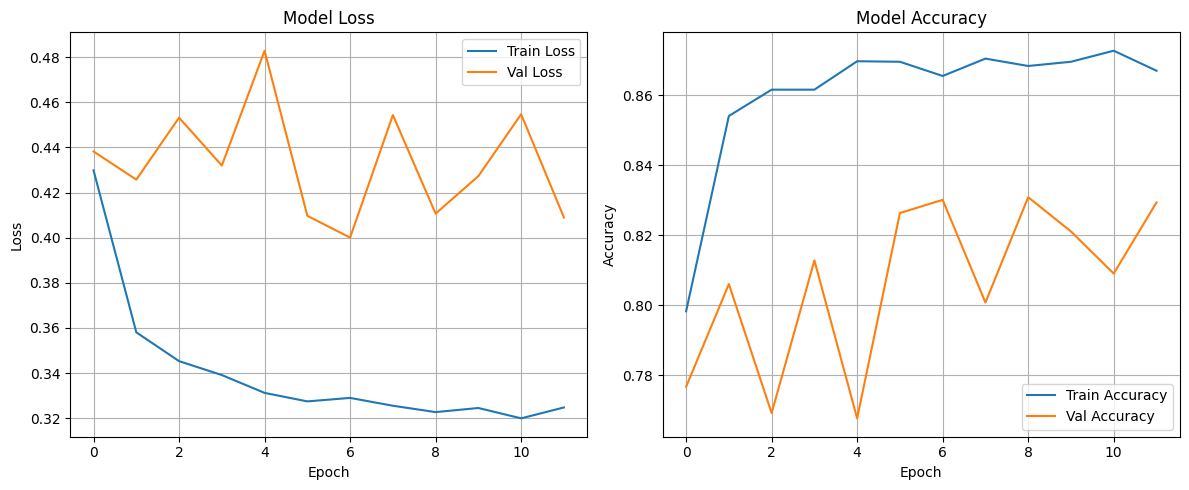

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
